# Group 4 Final Project: Analyzing funding and patent activity of NIMH researchers

**The goal of this project is to investigate federally funded National Institute of Mental Health (NIMH) researchers and subsequent patenting activity as a result of their research.**

* Our units of analysis are individual principal investigators (researchers) who were funded between Fiscal Years 2010 to 2018.

* The main data sources are Federal Reporter and PatentsView.

In [3]:
# Import libraries
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import preprocessing
from nltk import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
import string

[nltk_data] Downloading package stopwords to /Users/mbp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Step 1: Linking National Insititute of Health (NIH) Approved Grants to Respective Patents

We will start by importing all NIH grants since NIMH is a subagency of NIH.

* We will import NIH grants from federal reporter which include all approved federally funded grants between fiscal years 2010 - 2018. This will be our base sample.

* We will import NIH patents from PatentsView and directly link these patents to their respective projects.

* For Patents, we used the available data in the shared course drive on Yandex (2010-2018), as well as the patents data on NIH ExPORTER with a direct link between patents and projects (https://exporter.nih.gov/ExPORTER_Catalog.aspx?sid=0&index=3)

1) Importing the Grants data:

In [4]:
years = list(range(2010,2019))

data = [] # initiate list to store data frames:

for year in years:
    grant = pd.read_csv('/Users/mbp/Documents/NYU/Data Analytics for Public Policy/Final Project/FedRePORTER_PRJ_C_FY'+ str(year) + '.csv', skipinitialspace = True, low_memory = False)  # read-in a given file into a dataframe
    data.append(grant)  # append that dataframe to a list

# Concatenate all the dataframes together into one dataframe:
df = pd.concat(data)

In [5]:
# Filter to NIH only:
df = df[df['AGENCY'] == "NIH"].reset_index()

In [6]:
# Extract the core project number from the grants to match the project_id field in the patents:
df['core_project_number'] = df['PROJECT_NUMBER'].str.slice(1, 12)

In [7]:
df.shape

(646663, 26)

2) Importing the patents data:

* (1) From yandex folder provided to us (these were combined into one single CSV containing all years 2010-2018 and labeled as 'patents_all.csv')
* (2) From NIH-specific patents with the direct grant link (https://exporter.nih.gov/ExPORTER_Catalog.aspx?sid=0&index=3)

In [8]:
p1018 = pd.read_csv("/Users/mbp/Documents/NYU/Data Analytics for Public Policy/Final Project/patents_all.csv", engine = 'python')
patents = pd.read_csv('/Users/mbp/Documents/NYU/Data Analytics for Public Policy/Final Project/RePORTER_PATENTS_C_ALL.csv', skipinitialspace = True, low_memory = False)

In [9]:
patents.columns

Index(['PATENT_ID', 'PATENT_TITLE', 'PROJECT_ID', 'PATENT_ORG_NAME'], dtype='object')

In [10]:
p1018.columns

Index(['Unnamed: 0', 'patent_number', 'patent_title', 'patent_abstract',
       'patent_num_cited_by_us_patents', 'patent_date', 'app_date',
       'patent_firstnamed_inventor_name_first',
       'patent_firstnamed_inventor_name_last',
       'patent_firstnamed_inventor_city', 'patent_firstnamed_inventor_state',
       'patent_firstnamed_inventor_latitude',
       'patent_firstnamed_inventor_longitude',
       'patent_firstnamed_assignee_organization',
       'patent_firstnamed_assignee_city', 'patent_firstnamed_assignee_state',
       'patent_firstnamed_assignee_latitude',
       'patent_firstnamed_assignee_longitude'],
      dtype='object')

3) **Next, we need to merge the grants information to the respective patent information (i.e. link the grant project number to the respective patent number that corresponds to the specific patent associated with that project).**

* We do a full join (or outer join) to keep all projects regardless of whether it resulted in a patent or not.

In [11]:
grants_patents = df.merge(patents, left_on = "core_project_number", right_on = 'PROJECT_ID', how = 'outer')

In [12]:
# Make columns lower-case and clean up column names:
grants_patents.columns = grants_patents.columns.str.lower()
grants_patents = grants_patents.rename({'project_id_x': 'grant_project_id', 'project_id_y': 'patent_project_id'}, axis = 1)
grants_patents.columns

Index(['index', 'grant_project_id', 'project_terms', 'project_title',
       'department', 'agency', 'ic_center', 'project_number',
       'project_start_date', 'project_end_date', 'contact_pi_project_leader',
       'other_pis', 'congressional_district', 'duns_number',
       'organization_name', 'organization_city', 'organization_state',
       'organization_zip', 'organization_country', 'budget_start_date',
       'budget_end_date', 'cfda_code', 'fy', 'fy_total_cost',
       'fy_total_cost_sub_projects', 'core_project_number', 'patent_id',
       'patent_title', 'patent_project_id', 'patent_org_name'],
      dtype='object')

In [13]:
# Remove rows that only have a patent (these correspond to non-NIH patents associated with non-NIH grants):
grants_patents = grants_patents[grants_patents['grant_project_id'].notnull()]

**Since the NIH patent data with the direct link only has a limited number of columns (i.e. no information on the inventor, patent abstract, date, etc.), we need to merge our patents data with another set of patent information that contains these fields of interest.**

* We will merge our full NIH patents data with the patents data obtained from PatentsView from 2010-2018 (these are patents associated with projects that were funded between Fiscal Years 2010-2018)

In [14]:
grants_patents = grants_patents.merge(p1018, left_on = 'patent_id', right_on = 'patent_number', how = 'outer')

In [15]:
# Remove rows that only have a patent (these are non-NIH patents):
grants_patents = grants_patents[grants_patents['grant_project_id'].notnull()]
grants_patents.shape

(1035423, 48)

* Limitation: Reduction in rows, because some of the patents are not represented in the patents 10-18 data, and don't merge, so they are not included. This is because the data is limited to those years.

4) **Final dataframe:**

In [16]:
grants_patents.head()

,index,grant_project_id,project_terms,project_title,department,agency,ic_center,project_number,project_start_date,project_end_date,...,patent_firstnamed_inventor_name_last,patent_firstnamed_inventor_city,patent_firstnamed_inventor_state,patent_firstnamed_inventor_latitude,patent_firstnamed_inventor_longitude,patent_firstnamed_assignee_organization,patent_firstnamed_assignee_city,patent_firstnamed_assignee_state,patent_firstnamed_assignee_latitude,patent_firstnamed_assignee_longitude
0,15656.0,150649.0,Infectious Diseases Research,FACILITIES IMPROVEMENT FOR INFECTIOUS DISEASE ...,HHS,NIH,NCRR,1C06RR020088-01,10/20/2009,10/19/2014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15657.0,150652.0,Animal Experimentation,CONSTRUCTION OF THE MU ANIMAL RESEARCH CENTER,HHS,NIH,NCRR,1C06RR020544-01A1,10/20/2009,9/30/2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15658.0,150654.0,Biomedical Research; research facility,CONSTRUCTION OF A BIOMEDICAL RESEARCH FACILITY...,HHS,NIH,NCRR,1C06RR020547-01A1,2/1/2010,12/12/2014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15659.0,150655.0,Accreditation; Air; animal care; animal facil...,MCKINLY LABORATORY ANIMAL FACILITY RENOVATION ...,HHS,NIH,NCRR,1C06RR020606-01A1,12/10/2009,9/30/2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15660.0,150659.0,Extramural Activities; Facility Construction;...,PAR-04-122 EXTRAMURAL FACILITIES CONSTRUCTION ...,HHS,NIH,NCRR,1C06RR022056-01,3/4/2010,9/30/2014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step 2:  Examining the data, and exploratory analysis:

* Here, we begin to explore our linked data of NIH grants and patents and address our research question.

* To understand the overall landscape, we first investigate how many individual researchers and inventors exist in the data, and the overall patenting activity (how many inventions exist in this time frame)?

* In order to identify unique individuals, we use information about the researcher names and create an identifier based on their first, middle, and last names.

1) Create unique identifier for each individual in order to identify them:

In [17]:
grants_patents['pi_name_first'] = grants_patents['contact_pi_project_leader'].str.split(' ').str.get(1)
grants_patents['pi_name_middle'] = grants_patents['contact_pi_project_leader'].str.split(' ').str.get(2)
grants_patents['pi_name_last'] = grants_patents['contact_pi_project_leader'].str.split(' ').str.get(0)
grants_patents['pi_name_middle'] = grants_patents['pi_name_middle'].fillna('')
grants_patents['unique_id'] = grants_patents['pi_name_first'] + grants_patents['pi_name_middle'] + grants_patents['pi_name_last']
grants_patents.unique_id

0             MICHAELJOGLESBEE,
1          ROBERTDICKINSONHALL,
2                  JOHNHKROUSE,
3             CHARLESG.RIORDAN,
4               ANDREWSWEYRICH,
                   ...         
1035418      AMYELIZABETHBARTH,
1035419     ALEXANDERAORAEVSKY,
1035420              STEVENCHU,
1035421       ZDRAVKAOMEDAROVA,
1035422          STACEYGABRIEL,
Name: unique_id, Length: 1035423, dtype: object

1) Finding the number of unique principal investigators funded from FY 2010 - FY 2018 within NIH and NIMH:

In [18]:
grants_patents[grants_patents['ic_center']=="NIMH"]['unique_id'].nunique()

6725

2) Next, we parse out the first, middle, and last names of patent inventors to create a unique identifier for each inventor (not necessarily the same as the researcher / principal investigator)

In [19]:
grants_patents['inv_name_middle'] = grants_patents['patent_firstnamed_inventor_name_first'].str.split(' ').str.get(1)
grants_patents['inv_name_first'] = grants_patents['patent_firstnamed_inventor_name_first'].str.split(' ').str.get(0)
grants_patents['inv_name_last'] = grants_patents['patent_firstnamed_inventor_name_last']
grants_patents['inv_name_middle'] = grants_patents['inv_name_middle'].fillna('')
grants_patents['inv_unique_id'] = grants_patents['inv_name_first'] + grants_patents['inv_name_middle'] + grants_patents['inv_name_last']

In [20]:
grants_patents[grants_patents['ic_center']=="NIMH"]['inv_unique_id'].nunique()

116

* There are 116 unique inventors in NIMH from 2010-2018

3) Calculate total funding received by the top 10% of highest paid researchers in NIMH:

In [21]:
(grants_patents[grants_patents['ic_center']=="NIMH"].groupby('unique_id', as_index = False)['fy_total_cost'].sum().sort_values(by='fy_total_cost', ascending = False).reset_index().head(673)['fy_total_cost'].sum())/1000000000

9.042190273

### Step 3: Comparing funding and activity between "Established" and "New" researchers:

* Now that we have an exploratory look at how many researchers exist in our data, we want to assess whether there is a difference in the amount of funding given to a particular group of researchers, compared to another.


* Specifically, we want to define two groups:

    * **Established Researchers**: Researchers who are currently being funded for a project in FY 2010 - 2018 <u>that also had one or more projects that started before the year 2010</u>.
    * **New Researchers**: Researchers who are currently being funded for a project in FY 2010 - 2018 <u>that have one or more projects that started after 2010.</u>
    
    * For example, if I was a researcher who is currently being funded for a project but previously worked on a project in the past that started in 2002, I would be considered an Established Researcher.
    
    
* The motive behind creating these two groups and definitions is to distinguish between veteran researchers who may be  well known in the field and consistently receive grants, funding, and might generally be favored to produce quality results, and compare them to newer researchers who may have just received their first grant recently, and not have had time to to become established, but may still be working on important issues or topics in the field.



* Limitations to the definitions include the fact that a person who only worked on one project prior to 2010 will be considered "established", however they might not actually possess a lot of experience researching in the field. On the other hand, researchers may have worked in other agencies and may not show up in this data set until later, and will be considered "new" when they are actually experienced.


1) In order to create our two groups, we need to create a new column in our data that identifies whether an individual is 'established' or not, depending on that individuals earliest project start date. So, if someone's earliest project start date is before 2010, they will be classified as 'group 1', otherwise 'group 2'.

In [22]:
# first, extract project start year from 'project_start_year' column:
grants_patents['project_start_year'] = pd.DatetimeIndex(grants_patents['project_start_date']).year

2) Create a metric "established" which measures how established a researcher is. This code will check whether an individual's <u> minimum</u> "project_start_year" is less than 2010:

In [23]:
import numpy as np
grants_patents['established'] = np.where((grants_patents.groupby('unique_id')['project_start_year'].transform('min')) <=2010, 1, 0)

3) Investigating the compositions of both groups:

Below represents the total number of Established Researchers (GROUP 1) in NIMH:

In [24]:
grants_patents[(grants_patents['established']==1) & (grants_patents['ic_center']=="NIMH")]['unique_id'].nunique()

3943

Below represents the total number of New Researchers (GROUP 2) in NIMH:

In [25]:
grants_patents[(grants_patents['established']==0) & (grants_patents['ic_center']=="NIMH")]['unique_id'].nunique()

2782

In [26]:
# Create separate dataframes for each group:
group1 = grants_patents[(grants_patents['established']==1) & (grants_patents['ic_center']=="NIMH")]
group2 = grants_patents[(grants_patents['established']==0) & (grants_patents['ic_center']=="NIMH")]

4) Calculate number of unique grants for each group:

In [25]:
group1['grant_project_id'].nunique()

23729

In [26]:
group2['grant_project_id'].nunique()

9597

5) Calculate number of PI's with projects that have patents:

In [27]:
group1[group1['patent_id'].notnull()]['unique_id'].nunique()

172

In [28]:
group2[group2['patent_id'].notnull()]['unique_id'].nunique()

35

6) Calculate total funding received by each group (in billions)

In [29]:
(group1['fy_total_cost'].sum())/1000000000

11.352616923

In [30]:
(group2['fy_total_cost'].sum())/1000000000

4.067099361

Boxplot of average funding per PI in each group:

[Text(0, 0.5, 'Average Funding per PI (Millions)'),
 Text(0.5, 0, 'Group'),
 Text(0.5, 1.0, 'On Average, Junior Researchers Receive Less Funding per PI')]

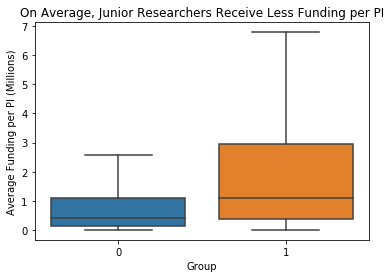

In [69]:
import seaborn as sns
box_plot = grants_patents[grants_patents['ic_center']=="NIMH"].groupby(['unique_id', 'established'])['fy_total_cost'].sum().to_frame().reset_index()
box_plot['fy_total_cost'] = box_plot['fy_total_cost']/1000000
sns.boxplot(x = 'established', y = 'fy_total_cost', data = box_plot, showfliers = False).set(title = "On Average, Junior Researchers Receive Less Funding per PI", xlabel='Group', ylabel='Average Funding per PI (Millions)')

7) Calculate total funding on patented research:

In [31]:
(group1[group1['patent_id'].notnull()]['fy_total_cost'].sum())/1000000000

2.742272669

In [32]:
(group2[group2['patent_id'].notnull()]['fy_total_cost'].sum())/1000000000

0.463675048

Highest paid individuals in Group 1:

In [33]:
group1.groupby('unique_id', as_index = False)['fy_total_cost'].sum().sort_values(by='fy_total_cost', ascending = False).reset_index().head(5)

,index,unique_id,fy_total_cost
0,1379,"HUGHROSEN,",717755784.0
1,2945,"PJEFFREYCONN,",296594283.0
2,646,"CRAIGLINDSLEY,",282851207.0
3,3398,"SOLOMONH.SNYDER,",209748798.0
4,1083,"ESSEN,DAVIDVAN",196452543.0


Highest paid individuals in Group 2:

In [34]:
group2.groupby('unique_id', as_index = False)['fy_total_cost'].sum().sort_values(by='fy_total_cost', ascending = False).reset_index().head(5)

,index,unique_id,fy_total_cost
0,426,"CARLOSZARATE,",157654606.0
1,895,"FENGZHANG,",113344577.0
2,2556,"SUSANAMARA,",89773897.0
3,2669,"VICTORWPIKE,",69464900.0
4,1112,"JAMESRABER,",67439949.0


8) Calculating total patents produced as a result of each group's research:

In [35]:
group1['patent_id'].nunique()

318

In [36]:
group2['patent_id'].nunique()

67

The differences between these two groups appears to be reasonable. Group 1, being established, has more patents associated with their projects that are being funded between FY 2010-2018 than Group 2, the newer group of researchers. They may not have had the time to complete their research and develop a patent. 

However, it is interesting to note that the new group has about 20% of the patents of Group 1.

9) Calculate range of total funding amounts for each group.

In [37]:
group1.groupby('unique_id')['fy_total_cost'].sum().to_frame().reset_index().describe()

,fy_total_cost
count,3.943000e+03
mean,2.879183e+06
std,1.473199e+07
min,0.000000e+00
25%,3.815170e+05
50%,1.102862e+06
75%,2.945012e+06
max,7.177558e+08


## Visualizing Activity of Researchers

10) Here is the distribution of group 1's unique projects by their start dates. This will help understand the current activity of established researchers.

In [39]:
plot1 = group1.groupby('project_start_year')['grant_project_id'].nunique().to_frame().reset_index()

Text(0.5, 1.0, 'Most have started new projects between 2010-2015')

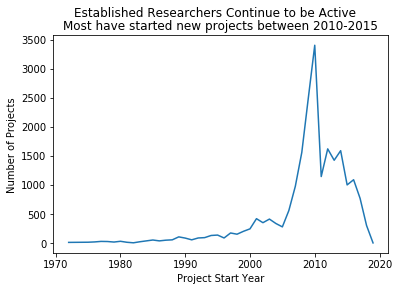

In [40]:
import matplotlib.pyplot as plt
plt.plot(plot1.project_start_year, plot1.grant_project_id)
plt.xlabel("Project Start Year")
plt.ylabel("Number of Projects")
plt.suptitle("Established Researchers Continue to be Active")
plt.title("Most have started new projects between 2010-2015")

The graph above is interesting, because it shows that Established Researchers are actively being funded and starting new research projects, suggesting that they might be 'popular' players and favored by agencies to conduct research.

### Step 4: Topic Modeling of Projects and Patents of Established and New Researchers:

Now that we see a clear difference in the funding and patenting activity of both groups, we will examine the topics of research conducted by the researchers, and the topics of the patents to see which fields are being priortized or funded more than others.

* We will use topic modeling with LDA analysis to examine the top words and topics associated with the projects and patents in each of the two groups.

1) First, extract all of the unique patents with their abstracts, associted with both groups 1 and 2. This will be our corpus of documents that contain abstracts of the patents.

In [41]:
group1_patents = group1.groupby('patent_id')['patent_abstract'].sum().to_frame().reset_index()
group1_patents.head(5)

,patent_id,patent_abstract
0,10017458,The invention relates to protein binding inter...
1,10039756,The disclosure relates to methods and composit...
2,10039813,The invention relates to methods of protecting...
3,10092199,0
4,10093898,Compositions and methods are provided for the ...


In [42]:
group2_patents = group2.groupby('patent_id')['patent_abstract'].sum().to_frame().reset_index()
group2_patents.head(5)

,patent_id,patent_abstract
0,10087168,The present technology relates to compounds an...
1,10093686,The present invention relates to compounds and...
2,10266886,0
3,10266887,0
4,10279051,0


In [43]:
# Remove patents without any abstract information:
group1_patents = group1_patents[group1_patents['patent_abstract'] != 0]
group2_patents = group2_patents[group2_patents['patent_abstract'] != 0]

2) Prepare patent abstract data for topic modeling:

In [44]:
# Extract abstracts column and convert to list:
group1_patents_list = group1_patents['patent_abstract'].values.tolist()
group2_patents_list = group2_patents['patent_abstract'].values.tolist()

# Initiate stemmer:
stemmer = SnowballStemmer("english")

# Function to tokenize words in each abstract, remove punctuation, and stemming:
def tokenize(text):
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))  # translator that replaces punctuation with empty spaces
    return [stemmer.stem(i) for i in text.translate(translator).split()]  # stemmer and tokenizing into words

# Import stop words and tokenize
stop_words = set(stopwords.words('english'))
stop_words = [tokenize(s)[0] for s in stop_words]

In [45]:
# Initialize vectorizer to create matrix of words for all abstracts:
vectorizer = CountVectorizer(analyzer="word",        # unit of features are single words rather than characters
                            tokenizer=tokenize,      # function to create tokens
                            ngram_range=(0,1),       # unigrams - single words
                            strip_accents='unicode', # remove accent characters
                            min_df = 0.05,           # only include words with minimum frequency of 0.05
                            max_df = 0.95,          # only include words with maximum frequency of 0.95
                            stop_words = stop_words)  # remove stop words

In [46]:
# Create bag of words for all abstracts in groups 1 and 2 and make into a dataframes:
group1_bow = vectorizer.fit_transform(group1_patents_list)
group1_features = vectorizer.get_feature_names()
group1_bow_df = pd.DataFrame(group1_bow.todense(), columns = group1_features)
group1_bow_df.head()

,1,2,3,5,abstract,acetylcholin,acid,activ,agent,alloster,...,tool,traumat,treat,treatment,use,various,vivo,weight,well,wherein
0,0,0,0,4,0,0,0,0,0,0,...,0,0,4,0,4,0,0,0,0,0
1,0,0,5,0,0,0,5,5,0,0,...,0,0,0,0,5,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0


In [47]:
group2_bow = vectorizer.fit_transform(group2_patents_list)
group2_features = vectorizer.get_feature_names()
group2_bow_df = pd.DataFrame(group2_bow.todense(), columns = group2_features)
group2_bow_df.head()

,2,5,acid,activ,adequ,administr,agent,also,alter,amelior,...,treat,treatment,trial,use,util,vector,virus,well,wherein,year
0,0,0,0,0,0,0,0,0,0,0,...,0,2,0,4,0,0,2,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,9,0,9,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,27,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,18,0,0,0,0,0,0,9,0
4,0,0,0,0,0,0,0,27,0,0,...,0,0,0,27,0,0,0,0,0,0


In [48]:
# Fit LDA model for group 1:
# Use 10 topics to start:

transformer = TfidfTransformer(norm = None, smooth_idf = True, sublinear_tf = True)
tfidf1 = transformer.fit_transform(group1_bow)

# Fitting LDA model
group1_lda = LatentDirichletAllocation(n_components = 7, learning_method='online')

# Document topics:
doctopic = group1_lda.fit_transform(tfidf1)

In [49]:
# Displaying the top keywords in each topic:
group1_kwd = []
for i,topic in enumerate(group1_lda.components_):
    word_idx = np.argsort(topic)[::-1][:10]
    keywords = ', '.join(group1_features[i] for i in word_idx)
    group1_kwd.append(keywords)
    print(i, keywords)

0 sequenc, disclos, herein, nucleic, acid, method, target, detect, specif, protein
1 intend, alloster, make, scan, purpos, abstract, art, tool, search, dysfunct
2 acid, wherein, nucleic, target, cell, method, compris, herein, invent, differ
3 e, g, cell, protect, neuron, subject, relat, invent, neurogenesi, death
4 injuri, traumat, brain, epilepsi, normal, stress, diseas, neurogenesi, post, cognit
5 imag, system, provid, magnet, reson, screen, generat, may, method, data
6 treatment, provid, compound, inhibit, use, diseas, composit, activ, disord, condit


In [50]:
# Fit LDA model for group 2:
# Use 10 topics to start:

transformer = TfidfTransformer(norm = None, smooth_idf = True, sublinear_tf = True)
tfidf2 = transformer.fit_transform(group2_bow)

# Fitting LDA model
group2_lda = LatentDirichletAllocation(n_components = 7, learning_method='online')

# Document topics:
doctopic2 = group2_lda.fit_transform(tfidf2)

In [51]:
# Displaying the top keywords in each topic:
group2_kwd = []
for i,topic in enumerate(group2_lda.components_):
    word_idx = np.argsort(topic)[::-1][:10]
    keywords = ', '.join(group2_features[i] for i in word_idx)
    group2_kwd.append(keywords)
    print(i, keywords)

0 present, use, diseas, receptor, brain, relat, disclos, treatment, compound, disord
1 contain, pharmaceut, depress, disclosur, provid, ketamin, includ, treatment, thereof, bipolar
2 base, disord, may, identifi, use, symptom, system, effect, one, determin
3 sampl, risk, determin, genet, assay, combin, associ, patient, obtain, thereof
4 crispr, vector, system, complex, sequenc, compon, provid, cas, design, format
5 genom, dna, compris, acid, least, termin, nucleic, wherein, locus, polypeptid
6 symptom, depress, recurr, intranas, year, episod, administr, respond, trial, amelior
